In [ ]:
# Educational Toolkit: Voila Quantum Dashboard Simulator
# This script sets up a Voila dashboard for simulating quantum circuits and visualizing results.
# -------- Imports --------
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from ipywidgets import VBox, HBox, IntSlider, FloatSlider, Dropdown, Button, Output
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
import random
import os
from datetime import datetime


In [ ]:
# -------- UI Elements --------
def classical_galton_box(n_layers, shots=10000):
    outcomes = [sum(random.choices([0, 1], k=n_layers)) for _ in range(shots)]
    return Counter(outcomes)

def biased_galton_box(n_layers, bias=0.7, shots=10000):
    outcomes = [sum([1 if random.random() < bias else 0 for _ in range(n_layers)]) for _ in range(shots)]
    return Counter(outcomes)

def quantum_galton_box(n_layers, shots=10000):
    qc = QuantumCircuit(n_layers, n_layers)
    for i in range(n_layers):
        qc.h(i)
    qc.measure(range(n_layers), range(n_layers))

    sim = AerSimulator()
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    result = job.result().get_counts()

    counts = Counter()
    for k, v in result.items():
        counts[k.count("1")] += v
    return counts

def noisy_quantum_box(n_layers, shots=10000):
    qc = QuantumCircuit(n_layers, n_layers)
    for i in range(n_layers):
        qc.h(i)
    qc.measure(range(n_layers), range(n_layers))

    noise_model = NoiseModel()
    error = depolarizing_error(0.05, 1)
    noise_model.add_all_qubit_quantum_error(error, ['h'])

    sim = AerSimulator(noise_model=noise_model)
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    result = job.result().get_counts()

    counts = Counter()
    for k, v in result.items():
        counts[k.count("1")] += v
    return counts


In [ ]:
# -------- Plotting Functions --------
def plot_distribution(counts, n_layers, title, save=False):
    x = list(range(n_layers + 1))
    y = [counts.get(i, 0) for i in x]

    plt.figure(figsize=(8, 5))
    plt.bar(x, y, color='skyblue')
    plt.title(title)
    plt.xlabel("Right Moves (1s)")
    plt.ylabel("Frequency")
    plt.grid(True)

    if save:
        os.makedirs("results", exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
        filename = f"results/{title.replace(' ', '_')}_{timestamp}.png"
        plt.savefig(filename)
        print(f"📁 Plot saved at: {filename}")

    plt.show()



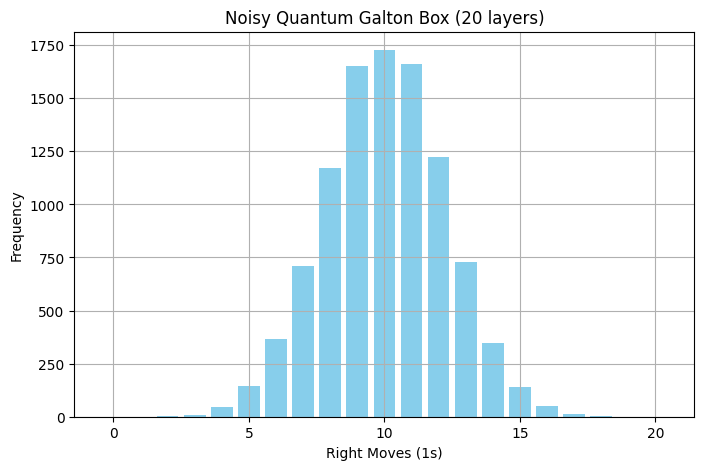

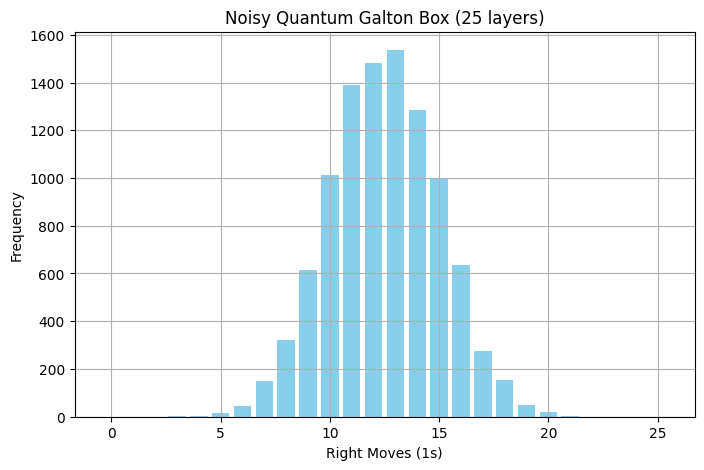

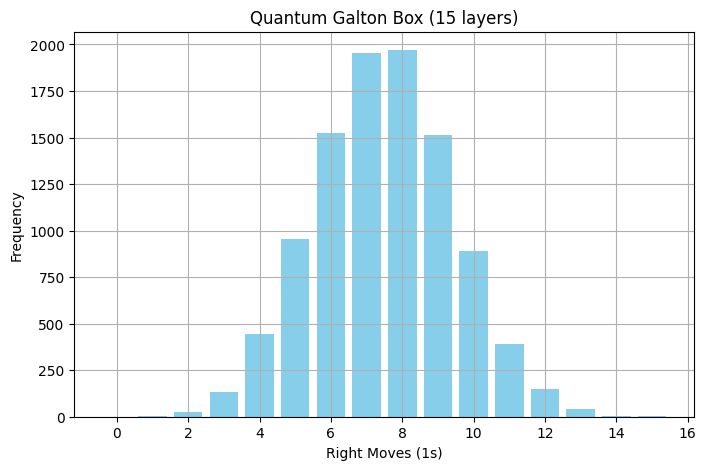

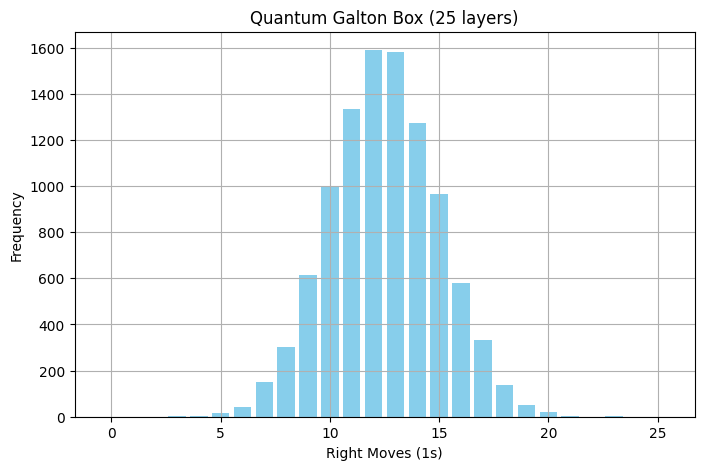

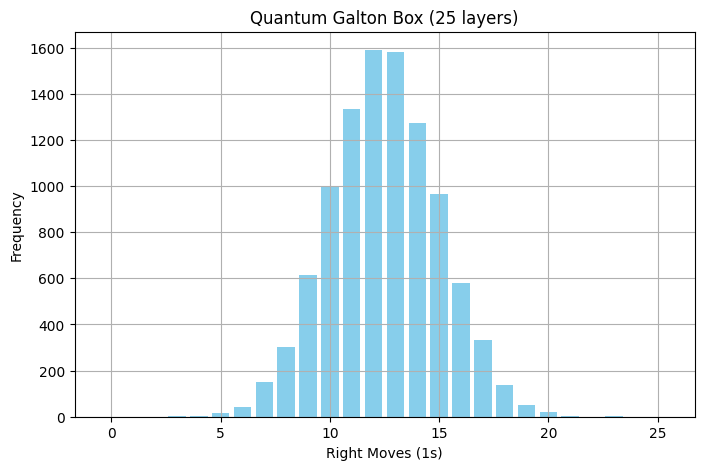

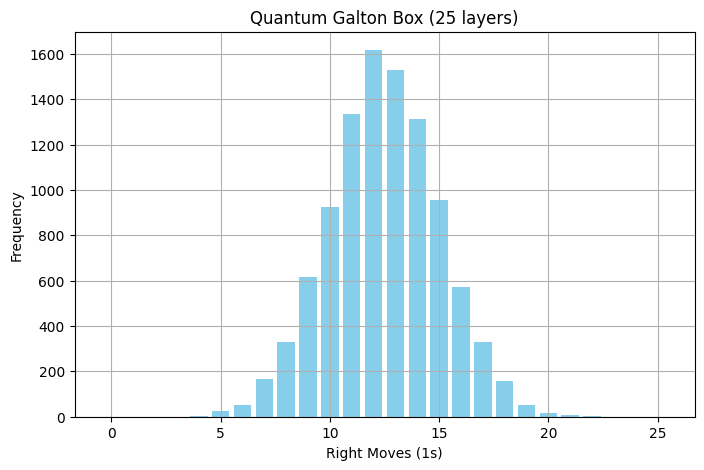

In [9]:
# -------- UI Setup --------
layer_slider = IntSlider(description="Layers", min=1, max=25, value=5)
bias_slider = FloatSlider(description="Bias", min=0.0, max=1.0, step=0.05, value=0.5)
method_dropdown = Dropdown(
    description="Method",
    options=["Classical", "Biased", "Quantum", "Noisy Quantum"],
    value="Classical"
)
run_button = Button(description="▶️ Run Simulation", button_style='success')
save_button = Button(description="💾 Save Image", button_style='info')
output_area = Output()


In [ ]:
# -------- UI Layout --------
global_counts = {}

def run_simulation(change=None):
    output_area.clear_output()
    with output_area:
        n = layer_slider.value
        method = method_dropdown.value
        bias = bias_slider.value

        if method == "Classical":
            counts = classical_galton_box(n)
        elif method == "Biased":
            counts = biased_galton_box(n, bias)
        elif method == "Quantum":
            counts = quantum_galton_box(n)
        elif method == "Noisy Quantum":
            counts = noisy_quantum_box(n)
        else:
            counts = {}

        title = f"{method} Galton Box ({n} layers)"
        plot_distribution(counts, n, title)
        global_counts["data"] = (counts, n, title)

def save_plot(change=None):
    if "data" in global_counts:
        counts, n, title = global_counts["data"]
        plot_distribution(counts, n, title, save=True)
    else:
        with output_area:
            print("⚠️ Run a simulation first.")



In [ ]:
# Bind buttons to functions
run_button.on_click(run_simulation)
save_button.on_click(save_plot)

ui = VBox([
    HBox([layer_slider, bias_slider]),
    HBox([method_dropdown, run_button, save_button]),
    output_area
])

display(ui)
# -------- UI Setup --------